In [1]:
# this one plots the overal histogram of the spots taking into account the specific time frame

In [2]:
# TODO: clean imports
# want to see the images inline
%matplotlib inline

# imports
# general 
import os
import glob
from functools import reduce
import re
import csv as csv
# scientific 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, datasets
from scipy.stats import norm, gamma
from scipy.optimize import curve_fit
from scipy import special

import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [37]:
# REMOVE:
# simple gamma function
def g_x(x, a, c):
    return x**(a - 1)*np.exp(-x)/special.gamma(a) + c

In [4]:
# function for loading one data-set
def load_data(file_path, skiprows_=1):
    data = np.loadtxt(file_path, delimiter = '\t', skiprows=skiprows_)
    # print(data.shape) 
    # handles some weird cases, e.g. when there is no data in the file
    if (len(data.shape) < 2):
        data = data[None, :]
    if (data.shape[1] == 0):
        I = np.array([0])
    else:
        I = data[:, -1]
    return I

In [21]:
# some folder magic 
# contains all csv files
folder = '/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/'

In [22]:
# at the moment we only have 4 timeframes
n_timeframes = 4

In [8]:
# possible labels 
stain = ['DPY-23_EX', 'WDR-5.2', 'MDH-1']
stage = 'E' # only embryos
comment = '' # only empty ones

In [23]:
# important indices
stain_columns = ['C0_stain', 'C1_stain', 'C2_stain', 'C3_stain', 'C4_stain']
type_columns = ['C0_type', 'C1_type', 'C2_type', 'C3_type', 'C4_type']
stain_prefix = np.array([['C1-', 'C2-', 'C3-', 'C4-', 'C5-']])
ext = '.csv'
filename_column = 'new filename'
nuclei_column = '#nuclei'

In [26]:
# read the db and parse images that we want to process
df = pd.read_csv(folder + "smFISH-database/N2-Table 1 updated.csv", sep=',', na_values=['']);
df.head()

,Line,ID,C0_lambda,C0_stain,C0_type,C1_lambda,C1_stain,C1_type,C2_lambda,C2_stain,...,comment,date,original filename,new filename,#nuclei,#C0_smfish,#C1_smfish,#C2_smfish,#C3_smfish,#C4_smfish
0,N2,1.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,not complete,11/17/2016,2016-11-17_N2-DPY-23-001.nd2,N2_1,2.0,NaN,NaN,NaN,NaN,NaN
1,N2,2.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,dirt,11/17/2016,2016-11-17_N2-DPY-23-002.nd2,N2_2,4.0,NaN,NaN,NaN,NaN,NaN
2,N2,3.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,"dirt, not complete",11/17/2016,2016-11-17_N2-DPY-23-003.nd2,N2_3,1.0,NaN,NaN,NaN,NaN,NaN
3,N2,4.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,NaN,11/17/2016,2016-11-17_N2-DPY-23-004.nd2,N2_4,1.0,NaN,NaN,NaN,NaN,NaN
4,N2,5.0,670.0,FISH,DPY-23_EX,488.0,AF,NaN,405.0,NUCLEAR,...,not complete,11/17/2016,2016-11-17_N2-DPY-23-005.nd2,N2_5,3.0,NaN,NaN,NaN,NaN,NaN


In [12]:
# this is general
# filter to have only *good* and *embryo* files
good_indices = np.logical_and((df['stage'] == stage).tolist() , (df['comment'].isnull()).tolist())
good_indices.shape[0]


print(np.sum(good_indices == True))

596


In [27]:
# choose necessary stains
dataset1 = []
df_good = (df[type_columns].astype(np.object) == stain[0]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].as_matrix()[row]
dataset1 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

In [28]:
# choose necessary stains
dataset2 = []
df_good = (df[type_columns].astype(np.object) == stain[1]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].as_matrix()[row]
dataset2 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

In [29]:
# choose necessary stains
dataset3 = []
df_good = (df[type_columns].astype(np.object) == stain[2]).loc[good_indices, :]
row, col = np.where(df_good)
n_samples = df.shape[0]
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].as_matrix()[row]
dataset3 = ["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

In [30]:
print(len(dataset1) + len(dataset2) + len(dataset3))

1146


In [31]:
def create_title(path, name_id=8):
    # get the name of the initial image
    image_name = path.split("/")[name_id] # was 8
    # print(path.split("/"))
    # create the full title 
    title = image_name[:-4]
    return title
# create_title("/Users/kkolyva/Desktop/n2/N2-results/all/C1-N2_9.csv")

In [32]:
labels = ['DPY-23_EX'] # ['DPY-23_EX', 'WDR-5.2', 'MDH-1']
color = '#BA5536'
if labels[0] == 'MDH-1':
    color = "#693D3D"

In [33]:
# actual plotting 

dataset_to_use = dataset1
if labels[0] == 'MDH-1':
    dataset_to_use = dataset3
    
dataset = []
p_dataset = []
for j in range(0, len(dataset_to_use)):
    tmp = folder + "csv-2/" + dataset_to_use[j] + ".csv"
    dataset.append(tmp)
    print(tmp)

/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_9.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_16.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_17.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_23.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_25.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_27.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_29.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_51.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_62.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_63.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-results-together/csv-2/C1-N2_64.csv
/Users/kkolyva/Desktop/2018-07-31-09-53-32-N2-all-resul

In [ ]:
folder_path = folder + "histograms-2/" + labels[0] + "/"

In [ ]:
# run over all images n_timeframes times to plot the correct images:

for t in n_timeframes:
    for idx in range(0, len(dataset)):
        if(not os.path.exists(dataset[idx])):
            # print("doesn't exist")
            continue
        
        # use try catch because some files might be empty or broken
        try: 
            print(dataset[idx])
            # load the data and scale it accordingly
            I = load_data(dataset[idx])
            I_res = I
            
            
        except(RuntimeError, TypeError, ValueError):
            print("There was an exception but we\'ll fix it for you")

### ?plt.hist

/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/total-2/DPY-23_EX/
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_279.csv
error: 0.030303030303 ; center: 1.0303030303
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_289.csv
error: 0.030303030303 ; center: 0.969696969697
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_290.csv
error: 0.030303030303 ; center: 1.0303030303
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_291.csv
error: 0.0606060606061 ; center: 1.06060606061
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_292.csv
error: 0.0606060606061 ; center: 1.06060606061
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_293.csv
error: 0.0 ; center: 1.0
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_294.csv
error: 0.0 ; center: 1.0
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_296.csv
error: 0.030303030303 ; center: 0.969696969697
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_298.csv
err

/Users/kkolyva/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in long_scalars
/Users/kkolyva/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:527: RuntimeWarning: invalid value encountered in subtract
  if (numpy.max(numpy.ravel(numpy.abs(sim[1:] - sim[0]))) <= xatol and
/Users/kkolyva/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:532: RuntimeWarning: invalid value encountered in subtract
  xr = (1 + rho) * xbar - rho * sim[-1]
/Users/kkolyva/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/kkolyva/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/kkolyva/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:574: Runti

error: 0.030303030303 ; center: 0.969696969697
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_346.csv
error: 0.030303030303 ; center: 0.969696969697
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_347.csv
error: 0.0 ; center: 1.0
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_348.csv
error: 0.0 ; center: 1.0
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_349.csv
error: 0.030303030303 ; center: 0.969696969697
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_350.csv
error: 0.0606060606061 ; center: 1.06060606061
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_352.csv
error: 0.0 ; center: 1.0
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_353.csv
error: 0.0606060606061 ; center: 0.939393939394
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_354.csv
error: 0.575757575758 ; center: 0.424242424242
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_355.csv
error: 0.0 ; center: 1.0
/Volumes/1TB/2

/Users/kkolyva/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1654: RuntimeWarning: invalid value encountered in true_divide
  place(output, cond, self._pdf(*goodargs) / scale)


error: 0.0 ; center: 1.0
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_393.csv
error: 0.030303030303 ; center: 1.0303030303
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_394.csv
error: 0.030303030303 ; center: 1.0303030303
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_395.csv
error: 0.0606060606061 ; center: 1.06060606061
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_447.csv
error: 0.030303030303 ; center: 1.0303030303
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_448.csv
error: 0.0 ; center: 1.0
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_449.csv
error: 0.030303030303 ; center: 0.969696969697
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_451.csv
error: 0.0606060606061 ; center: 0.939393939394
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_452.csv
error: 0.0 ; center: 1.0
/Volumes/1TB/2018-06-14-12-36-00-N2-full-stack/csv-2/C1-N2_453.csv
error: 0.030303030303 ; center: 0.96969696969

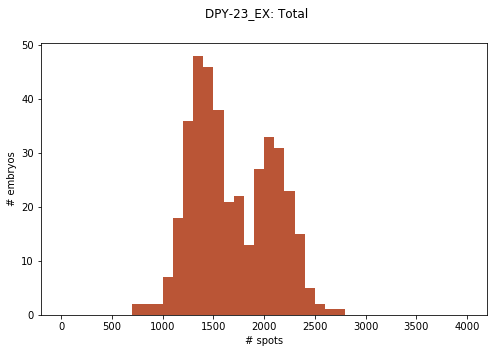

DOGE!


In [56]:
# make the plot with the total number of the detections
folder_path = folder + "total-2/" + labels[0] + "/"
print(folder_path)

result_set = {}

# actual plotting 
for idx in range(0, len(dataset)):    
    if(not os.path.exists(dataset[idx])):
        # print("doesn't exist")
        continue
   
    try:
        print(dataset[idx])

        # load the data and scale it accordingly
        I = load_data(dataset[idx])
        I_res = I

        # some const params for all graphs
        num_bins = 100; 
        # graph [xmin, xmax]
        xmin = 0
        xmax = 3
        binwidth = (xmax - xmin)/(num_bins - 1)
        bins = np.arange(xmin, xmax + binwidth, binwidth)

        binned_values, real_bins = np.histogram(I_res, bins)
        use_median = np.median(I_res)
        # inititally there was use_median/2 
        fit_alpha, fit_loc, fit_beta = gamma.fit(I_res, loc=use_median/2, scale=1/np.max(binned_values))
        # normalization factor
        factor = np.sum(binned_values*np.diff(real_bins))
        x = np.linspace(xmin, xmax, 1000)
        y = gamma.pdf(x, fit_alpha, fit_loc, fit_beta)*factor
        yhat = gamma.pdf(real_bins, fit_alpha, fit_loc, fit_beta)*factor

        if (np.any(np.isnan(yhat))):
            continue

        # should be close to 1
        x_center = real_bins[np.argmax(yhat)]

        # error less than 15%
        print ("error:", np.abs(x_center - 1), "; center:", x_center)
        if (np.abs(x_center - 1) < 0.15):    
            title = create_title(dataset[idx], name_id=5)
            result_set[title] = len(I)   
    except(RuntimeError, TypeError, ValueError, StopIteration):
        print("There was an exception but we\'ll fix it for you")
            
print(list(result_set.values()))        
        
# these are subject to change
xmin = 0
xmax = 4000
binwidth = 100
num_bins = (xmax - xmin) / binwidth + 1;
bins = np.arange(xmin, xmax + binwidth, binwidth)
xlimits = [xmin, xmax]

spots_total = list(result_set.values())

fig = plt.figure(figsize=(8,5))
fig.suptitle(labels[0] + ": Total")
plt.hist(spots_total, bins=bins, color=color, label=labels, normed=False)

plt.xlabel("# spots")
plt.ylabel("# embryos")

df_center = pd.DataFrame(list(result_set.items()), columns=['filename', 'total'])
if not os.path.exists(folder_path):
    os.makedirs(folder_path )
df_center.to_csv(folder_path + labels[0] +"-total.csv", index=False, header=True, encoding='utf-8', mode = 'w' )
plt.savefig(folder_path + labels[0] + "-total.pdf") 
plt.show()
        
print ("DOGE!")  